In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
np.set_printoptions(precision=3, linewidth=120)
from copy import copy
from tqdm import *
from drift_qec.Q import *

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [56]:
D = 0.25 * np.pi
L = SENSOR(D, D, D)
np.round(np.dot(np.linalg.inv(np.dot(L.T, L)), L.T), 2)

array([[ 0.22,  0.22, -0.11,  0.22, -0.11,  0.22,  0.56, -0.11, -0.11],
       [-1.  ,  1.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  , -0.  , -0.  ],
       [ 0.  ,  0.  , -0.  , -1.  ,  0.  ,  1.  ,  0.  , -0.  , -0.  ],
       [ 0.22,  0.22, -0.11, -0.11,  0.56, -0.11, -0.11,  0.22,  0.22],
       [ 0.  ,  0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  , -1.  ,  1.  ],
       [-0.11, -0.11,  0.56,  0.22, -0.11,  0.22, -0.11,  0.22,  0.22]])

In [46]:
channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                  Q=np.linalg.qr(np.random.randn(3,3))[0],
                  n=N, d1=D0, d2=D0, d3=D0)

In [47]:
channel.sample_data()

array([ 0.246,  0.369,  0.385,  0.246,  0.369,  0.385,  0.245,  0.369,  0.386])

In [48]:
channel.d1

0.001

In [28]:
p = 0.01
D0 = 0.001
N = 100000*int(2.0*np.log(1.0/D0))
T = np.arange(1000)
N_TRIALS = 10
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N, d1=D0, d2=D0, d3=D0)
    for t in T:
        channel.update()
        QAhat = np.linalg.svd(channel.Ahat)[0]
        Qhat, phat = np.linalg.svd(channel.Mhat)[0:2]
        maxidx = np.argmax(phat)
        RECORDS.append({"t": t,
                        "d": channel.d1,

                        "C_Mhat":     np.linalg.norm(channel.C-channel.Mhat),
                        "Mhat_Ahat":  np.linalg.norm(channel.Ahat-channel.Mhat),
                        "Ahat_M":     np.linalg.norm(channel.C-channel.Ahat),

                        "Q_Qhat":     np.linalg.norm(channel.Q - Qhat),
                        "Qhat_QAhat": np.linalg.norm(Qhat - QAhat),
                        "QAhat_Q":    np.linalg.norm(QAhat - channel.Q),

                        "q_qhat":     np.linalg.norm(channel.Q[maxidx, :] - Qhat[maxidx, :]),
                        "qhat_qahat": np.linalg.norm(Qhat[maxidx, :] - QAhat[maxidx, :]),
                        "qahat_q":    np.linalg.norm(QAhat[maxidx, :] - channel.Q[maxidx, :]),

                        "c11_m11": np.abs(channel.C[0,0] - channel.Mhat[0,0]),
                        "c22_m22": np.abs(channel.C[1,1] - channel.Mhat[1,1]),
                        "c33_m33": np.abs(channel.C[2,2] - channel.Mhat[2,2]),
                        "c12_m12": np.abs(channel.C[0,1] - channel.Mhat[0,1]),
                        "c13_m13": np.abs(channel.C[0,2] - channel.Mhat[0,2]),
                        "c23_m23": np.abs(channel.C[1,2] - channel.Mhat[1,2]),

                        "c11_a11": np.abs(channel.C[0,0] - channel.Ahat[0,0]),
                        "c22_a22": np.abs(channel.C[1,1] - channel.Ahat[1,1]),
                        "c33_a33": np.abs(channel.C[2,2] - channel.Ahat[2,2]),
                        "c12_a12": np.abs(channel.C[0,1] - channel.Ahat[0,1]),
                        "c13_a13": np.abs(channel.C[0,2] - channel.Ahat[0,2]),
                        "c23_a23": np.abs(channel.C[1,2] - channel.Ahat[1,2])
                    })
#         Dt = np.min([np.max([p ** 2, D0 ** (0.5 * (t-1.0))]), p])
#         channel.d1 = Dt
#         channel.d2 = Dt
#         channel.d3 = Dt

df = pd.DataFrame(RECORDS)
df.to_csv("decayd.csv")

df = pd.read_csv("decayd.csv", index_col=0)
cols = ['t', 'd',
 'Ahat_M',   'C_Mhat', 'Mhat_Ahat',
 'QAhat_Q',  'Q_Qhat', 'Qhat_QAhat',
 'q_qhat',  'qahat_q', 'qhat_qahat',
 'c11_a11', 'c22_a22', 'c33_a33',
 'c12_a12', 'c13_a13', 'c23_a23',
 'c11_m11', 'c22_m22', 'c33_m33',
 'c12_m12', 'c13_m13', 'c23_m23']
df = df[cols]

data = df.groupby("t").mean()

data.head(20)

,d,Ahat_M,C_Mhat,Mhat_Ahat,QAhat_Q,Q_Qhat,Qhat_QAhat,q_qhat,qahat_q,qhat_qahat,...,c33_a33,c12_a12,c13_a13,c23_a23,c11_m11,c22_m22,c33_m33,c12_m12,c13_m13,c23_m23
t,,,,,,,,,,,,,,,,,,,,,
0,0.001,0.856097,0.397823,0.534651,2.153633,1.576445,1.648528e+00,0.778999,0.918448,7.503898e-01,...,0.000260,0.294267,0.283177,0.322673,0.037303,0.058476,0.060600,0.138075,0.090212,0.132265
1,0.001,0.689876,0.416234,0.339095,1.524648,1.338668,4.000000e-01,0.655964,0.731545,1.865678e-01,...,0.124545,0.138459,0.318044,0.190008,0.095779,0.132363,0.078380,0.105957,0.152799,0.131035
2,0.001,0.492848,0.343687,0.199378,1.470296,1.018224,7.656854e-01,0.508148,0.623668,2.855040e-01,...,0.111471,0.103261,0.220855,0.133846,0.114396,0.088002,0.073980,0.099685,0.122349,0.104535
3,0.001,0.392786,0.289429,0.125303,1.458464,1.268026,2.828427e-01,0.650023,0.672146,6.527244e-02,...,0.104729,0.145256,0.153994,0.063169,0.057579,0.074815,0.069986,0.118783,0.095273,0.056184
4,0.001,0.389038,0.299547,0.111624,1.290502,1.530748,2.828427e-01,0.826290,0.647828,1.936177e-01,...,0.077567,0.125963,0.151868,0.084259,0.053309,0.073797,0.050784,0.104484,0.103472,0.073245
5,0.001,0.396708,0.327582,0.089309,1.699970,1.713517,7.656854e-01,0.924800,0.911026,2.510307e-01,...,0.074335,0.145475,0.126729,0.104506,0.057550,0.071215,0.055555,0.126268,0.099475,0.092104
6,0.001,0.397654,0.343978,0.070353,1.755925,1.780143,4.828427e-01,0.933974,0.931750,2.328676e-01,...,0.065907,0.146662,0.142178,0.083133,0.084116,0.085323,0.052312,0.132857,0.111086,0.081948
7,0.001,0.363489,0.318806,0.052786,1.460414,1.296280,2.000000e-01,0.618839,0.696655,8.094137e-02,...,0.057591,0.119055,0.133950,0.070331,0.089144,0.092722,0.043625,0.113594,0.104660,0.074966
8,0.001,0.329324,0.292753,0.043670,1.667449,1.667449,1.272141e-15,0.884274,0.884274,4.503386e-16,...,0.064940,0.112817,0.117720,0.068373,0.071125,0.076195,0.054935,0.108686,0.091264,0.070921


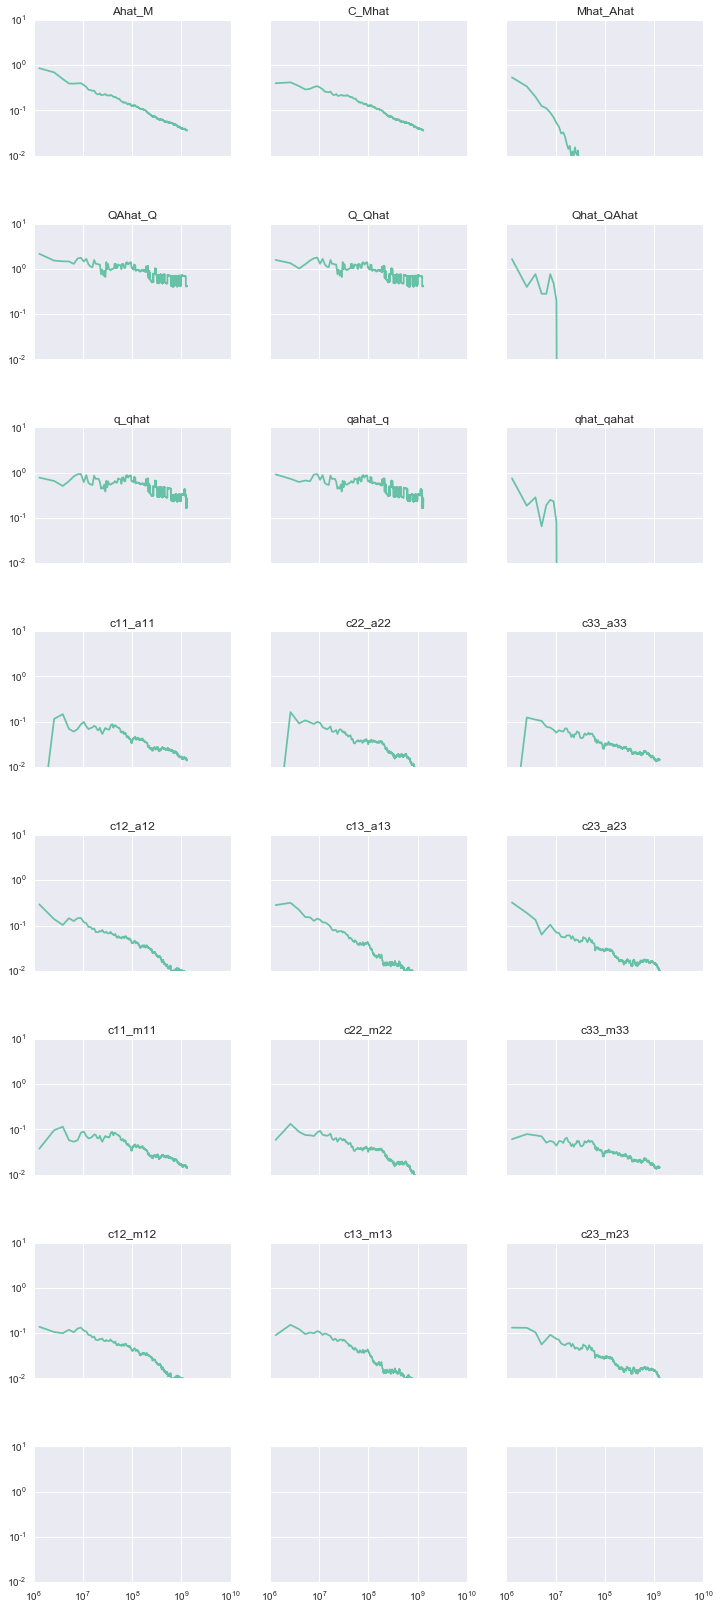

In [45]:
fig, axs = plt.subplots(8, 3, figsize=(12,28),
                        sharey=True, sharex=True)
PAL = sns.color_palette("BuGn_r", len(df["d"].unique()))
axs[0,0].set_ylim([1e-2, 1e1])

for idx, (col, y) in enumerate(data.drop("d", axis=1).iteritems()):
    axs[int(idx/3), idx%3].loglog((y.index.values+1)*N, y.values, c = PAL[0])
    axs[int(idx/3), idx%3].set_title(col)